<a href="https://colab.research.google.com/github/aldiekawahyu/manajerku-inventory-management/blob/main/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Data Preprocessing

In [7]:
def preprocess_data(sales_data, prediction_period):
  def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))

  def shift_series_in_df(df, days_delta, series_names=[]):
    shifted = pd.DataFrame(index=df.index.copy())
    sign = 'future' if np.sign(days_delta) < 0 else 'past'
    for series_name in series_names:
      shifted['{}_{}_{}'.format(series_name,sign,np.abs(days_delta))] = \
        shift_series(df[series_name], days_delta)
    return shifted
      
  def stack_shifted_sales(df, days_delta=30):
    names = item_list
    dfs = [df.copy()]
    abs_range = range(1, days_delta+1) if days_delta > 0 else range(days_delta, 0)
    for day_offset in abs_range:
      delta = -day_offset
      shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
      dfs.append(shifted)
    return pd.concat(dfs, axis=1, copy=False)
  
  # Import data
  df = pd.read_csv(sales_data)
  df.date = pd.to_datetime(df.date)
  df.index = df.date
  df = df.drop(['date'], axis=1)
  df = df.asfreq('D').fillna(0) # Fill missing dates (if any) with 0
  item_list = df.columns

  from datetime import timedelta
  last_train_date = df.index[-1]
  first_test_date = last_train_date + timedelta(days=1)

  # Appending data
  for i in range(prediction_period):
    df = df.append(pd.DataFrame(index=[df.index[-1] + timedelta(days=1)]))
  df = df.fillna(0)
  # is_train
  df['is_train'] = np.concatenate([np.repeat(True, df.shape[0]-prediction_period), np.repeat(False, prediction_period)])
  # weekday and month
  df_weekday = pd.get_dummies(df.index.weekday, prefix='weekday')
  df_weekday.index = df.index
  df_month = pd.get_dummies(df.index.month, prefix='month')
  df_month.index =  df.index
  df = pd.concat([df_weekday, df_month, df], axis=1)
  
  # Shifting
  df_shifted = stack_shifted_sales(df, days_delta=-1)
  df_shifted = df_shifted.dropna()

  # Column
  sales_columns = [column for column in df_shifted.columns if '_sales' in column and '_sales_' not in column]
  stacked_sales_columns = [column for column in df_shifted.columns if '_sales_' in column]
  other_columns = [column for column in df_shifted.columns if column not in set(sales_columns) and column not in set(stacked_sales_columns)]
  sales_columns = sorted(sales_columns)
  stacked_sales_columns = sorted(stacked_sales_columns)
  new_columns = other_columns + stacked_sales_columns + sales_columns
  df_shifted = df_shifted.reindex(columns=new_columns)

  # Scaling
  from sklearn.preprocessing import MinMaxScaler
  columns_to_scale = [column for column in df_shifted.columns if 'weekday' not in column and 'month' not in column]
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_cols = scaler.fit_transform(df_shifted[columns_to_scale])
  df_shifted[columns_to_scale] = scaled_cols

  # Train test
  df_train = df_shifted[df_shifted['is_train'] == True].drop('is_train', axis=1)
  df_pred = df_shifted[df_shifted['is_train'] == False].drop('is_train', axis=1)
  X_columns_stacked = [column for column in df_train.columns if '_past_' in column]
  X_columns_caldata = [column for column in df_train.columns if 'weekday' in column or 'month' in column]
  X_columns = X_columns_stacked + X_columns_caldata
  X = df_train[X_columns]
  X_colset = set(X_columns)
  y_columns = [column for column in df_train.columns if column not in X_colset]
  y = df_train[y_columns]
  y_pred = df_pred[y_columns]
  X_pred = df_pred[X_columns]
  X_vals = X.values.reshape((X.shape[0], 1, X.shape[1]))
  
  return X, y, X_pred, y_pred, scaler

# Prediction

## h5

In [17]:
# def model_eval(model, X, y, X_pred, y_pred, scaler, prediction_period=30, toint=True):
def model_eval(model, data='sample_sales_data.csv', prediction_period=30, toint=True):
  def unscale(y_arr, scaler, df_template, toint=toint):
    columns_to_scale = [column for column in df_template.columns if 'weekday' not in column and 'month' not in column]
    tmp = df_template.copy()
    tmp[y.columns] = pd.DataFrame(y_arr, index=tmp.index)
    tmp[columns_to_scale] = scaler.inverse_transform(tmp[columns_to_scale])
    if toint:
        return tmp[y.columns].astype(int)
    return tmp[y.columns]

  # Preprocess
  X, y, X_pred, y_pred, scaler = preprocess_data(data, prediction_period)

  sales_x_columns = [column for column in X.columns if 'sales' in column]
  sales_x_idxs = [X.columns.get_loc(column) for column in sales_x_columns]
  sales_y_columns = [column for column in y_pred.columns if 'sales' in column]
  sales_y_idxs = [y_pred.columns.get_loc(column) for column in sales_y_columns]
  y_pred_arr = np.zeros(y_pred.shape) # (30,10)

  # iterate
  x_next = X.iloc[0].values
  for i in range(0, prediction_period):     
    x_arr = np.array([x_next])
    x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
    y_pred_arr[i] = model.predict(x_arr)[0]
    try:
      x_next = X.iloc[i+1].values
      x_next[sales_x_idxs] = y_pred_arr[i][sales_y_idxs]
    except IndexError:
      pass
  
  # Unscale
  df_template = pd.concat([X_pred, y_pred], axis=1)
  df_template['is_train'] = np.repeat(False, df_template.shape[0])
  prediction = unscale(y_pred_arr, scaler, df_template, toint)
  return prediction

## tflite

In [36]:
def import_model(tflite_model_file='model.tflite'):  
  with open(tflite_model_file, 'rb') as f:
    tflite_model = f.read()

  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_shape = interpreter.get_input_details()[0]['shape']
  output_shape = interpreter.get_output_details()[0]['shape']
  input_index = interpreter.get_input_details()[0]['index']
  output_index = interpreter.get_output_details()[0]['index']

  return tflite_model, interpreter, input_shape, output_shape, \
    input_index, output_index

# Main

In [ ]:
# Import Model tflite
from google.colab import files
files.upload()

In [ ]:
# Import model h5
from google.colab import files
files.upload()

In [ ]:
# Import Data
from google.colab import files
files.upload()

In [ ]:
modelh5 = tf.keras.models.load_model('model.h5')
config = modelh5.get_config() # Returns pretty much every information about your model
print(config["layers"][0]["config"]["batch_input_shape"]) # returns a tuple of width, height and channels

In [23]:
prediction = model_eval(modelh5, data='sample_sales_data.csv')
prediction.to_csv('sales_prediction.csv')
prediction

,item_10_sales,item_1_sales,item_2_sales,item_3_sales,item_4_sales,item_5_sales,item_6_sales,item_7_sales,item_8_sales,item_9_sales
2018-01-01,30,32,15,35,19,12,12,30,38,44
2018-01-02,32,34,15,36,21,12,12,32,39,45
2018-01-03,34,38,17,39,23,14,13,35,43,49
2018-01-04,36,39,18,41,24,14,14,36,45,51
2018-01-05,39,42,19,44,26,15,15,39,47,55
2018-01-06,30,32,15,35,20,12,12,30,37,44
2018-01-07,32,35,16,37,21,13,13,33,40,46
2018-01-08,31,33,15,35,20,12,12,31,38,44
2018-01-09,32,34,16,36,21,12,12,32,40,46
2018-01-10,35,38,17,39,23,14,14,35,43,49


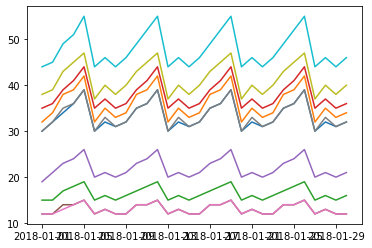

In [42]:
import matplotlib.pyplot as plt
plt.plot(prediction)
plt.show()k

In [39]:
tflite_model, interpreter, input_shape, output_shape, \
    input_index, output_index = import_model()

In [40]:
X, y, X_pred, y_pred, scaler = preprocess_data(sales_data='sample_sales_data.csv', prediction_period=30)